In [49]:
!pip uninstall -q -y tensorflow
!pip install -q --no-cache-dir tf-nightly
!pip install -q -U tensorboard

In [46]:
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
import datetime
from IPython import display

print("Tensorflow Version: {}".format(tf.__version__))
print("GPU {} available.".format("is" if tf.config.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.4.0-dev20200712
GPU is available.


In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12210685570355892293, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13341090458558437676
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3544721922505534261
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11132984384
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 8076211207855718882
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

This notebook demos image-to-image translation using conditional GAN models, which is described in [Image-to-Image Translation with Conditional Adversarial Networks](https://arxiv.org/abs/1611.07004). Here we convert the building facades to real buildings. We are going to use the [CMP Facade Dataset](http://cmp.felk.cvut.cz/~tylecr1/facade/). The following is the example.

![](https://www.tensorflow.org/images/gan/pix2pix_1.png)
![](https://www.tensorflow.org/images/gan/pix2pix_2.png)

# Load the Dataset

You can download the dataset from the [link](https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets). In the following, we are going to process the dataset in several steps.

* In the random jittering, the image is resized to `286 x 286` and is randomly cropped to `256 x 256`.

* In the random mirroring, the image is randomly flipped horizontally, i.e. from left to right.

In [4]:
datasetURL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

zipPath = tf.keras.utils.get_file(fname='facades.tar.gz', 
                                  origin=datasetURL, 
                                  extract=True)

PATH = os.path.join(os.path.dirname(zipPath), 'facades')

In [5]:
BUFFERSIZE = 300
BATCHSIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
def load_image(imagePath):
  image = tf.io.read_file(imagePath)
  image = tf.image.decode_jpeg(image)

  # [256, 512, 3]
  window = tf.shape(image)[1] // 2
  real_image = image[:, :window, :]
  input_image = image[:, window:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

Each image contains both the real and the input images. You can access them by slicing the image array along axis 1.

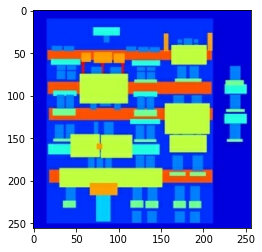

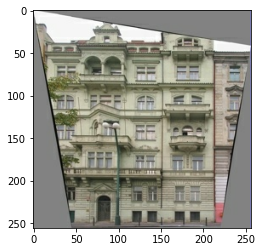

In [7]:
imagePath = os.path.join(PATH, "train", "100.jpg")
input_img, real_img = load_image(imagePath=imagePath)

plt.figure()
plt.imshow(input_img / 255.0)
plt.show()

plt.figure()
plt.imshow(real_img / 255.0)
plt.show()

In [8]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, 
                                size=[height, width], 
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, 
                               size=[height, width], 
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

In [9]:
def random_crop(input_image, real_image):
  stack_images = tf.stack([input_image, real_image], axis=0)
  cropped_images = tf.image.random_crop(stack_images, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_images[0], cropped_images[1]

Normalize the image to [-1, 1].

In [10]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1
  return input_image, real_image 

In [11]:
@tf.function
def random_jitter(input_image, real_image):
  # resize the image to 286 x 286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly crop the image to 256 x 256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # random flipping in horizontal
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

You can process the dataset in a way described in the paper.

* Resize an image to a bigger one.
* Randomly crop it to a fixed size.
* Randomly flip it in horizontal.

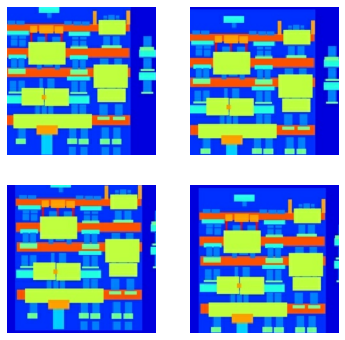

In [12]:
plt.figure(figsize=(6, 6))
for i in range(4):
  input_image, real_image = random_jitter(input_img, real_img)
  plt.subplot(2, 2, i+1)
  plt.imshow(input_image / 255.0)
  plt.axis("off")
plt.show()

Next, we concatenate these steps together to process the dataset for the training and the testing.

In [13]:
def load_image_train(fileName):
  input_image, real_image = load_image(fileName)
  # you can jitter the dataset while trainning
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [14]:
def load_image_test(fileName):
  input_image, real_image = load_image(fileName)
  input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)
  return input_image, real_image

In [15]:
input_image, real_image = load_image_train(imagePath)
print(input_image.shape, real_image.shape)

input_image, real_image = load_image_test(imagePath)
print(input_image.shape, real_image.shape)

(256, 256, 3) (256, 256, 3)
(256, 256, 3) (256, 256, 3)


# Input Pipeline

In [16]:
!ls -al {PATH}

total 28
drwxrwxrwx 5 8140  779  4096 Nov 21  2016 .
drwxr-xr-x 3 root root  4096 Jul 13 02:12 ..
drwxrwxrwx 2 8140  779  4096 Nov 21  2016 test
drwxrwxrwx 2 8140  779 12288 Nov 21  2016 train
drwxrwxrwx 2 8140  779  4096 Nov 21  2016 val


In [17]:
train_dataset = tf.data.Dataset.list_files(PATH + "/train/*.jpg")
train_dataset = train_dataset.map(load_image_train, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFERSIZE)
train_dataset = train_dataset.batch(BATCHSIZE)

In [18]:
test_dataset = tf.data.Dataset.list_files(PATH + "/test/*.jpg")
test_dataset = test_dataset.map(load_image_test, 
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCHSIZE)

# Build the Generator

The generator model is basically a modified U-Net.

* For the encoder part, a block consists of a Conv, a Batchnorm, and a Leakyrelu.
* For the decoder part, a block consists of a Transposed Conv, a Batchnorm, a dropout (for the first 3 layers), and a Relu.
* A skip connection (concatenation) links between the encoder and the decoder.

In [19]:
def downsample(filters, size, applyBatchnorm=True):
  initializer = tf.random_normal_initializer(mean=0, stddev=0.02)

  model = tf.keras.Sequential()
  model.add(
      tf.keras.layers.Conv2D(filters=filters, 
                             kernel_size=size, 
                             strides=(2, 2), 
                             padding="same", 
                             kernel_initializer=initializer,
                             use_bias=False))
  
  if applyBatchnorm:
    model.add(tf.keras.layers.BatchNormalization())
  
  model.add(tf.keras.layers.LeakyReLU())
  return model

In [20]:
downModel = downsample(3, 4)
downResult = downModel(tf.expand_dims(input_img, axis=0))
print(downResult.shape)

(1, 128, 128, 3)


In [21]:
def upsample(filters, size, applyDropout=False):
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.02)

  model = tf.keras.Sequential()
  model.add(
      tf.keras.layers.Conv2DTranspose(filters=filters, 
                                      kernel_size=size, 
                                      strides=(2, 2), 
                                      padding="same", 
                                      kernel_initializer=initializer, 
                                      use_bias=False))
  model.add(tf.keras.layers.BatchNormalization())

  if applyDropout:
    model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(tf.keras.layers.ReLU())
  return model

In [22]:
upModel = upsample(3, 4)
upResult = upModel(downResult)
print(upResult.shape)

(1, 256, 256, 3)


In [23]:
OUTPUT_CHANNEL = 3

In [24]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  # down sample
  downSamples = [\
    downsample(64, 4, applyBatchnorm=False),  # [bs, 128, 128, 64]
    downsample(128, 4),                       # [bs, 64, 64, 128]
    downsample(256, 4),                       # [bs, 32, 32, 256]
    downsample(512, 4),                       # [bs, 16, 16, 512]
    downsample(512, 4),                       # [bs, 8, 8, 512]
    downsample(512, 4),                       # [bs, 4, 4, 512]
    downsample(512, 4),                       # [bs, 2, 2, 512]
    downsample(512, 4),                       # [bs, 1, 1, 512]
  ]

  # up sample
  # notice that lots of layers are connected with a skip connection
  upSamples = [\
    upsample(512, 4, applyDropout=True),      # [bs, 2, 2, 512] -> [bs, 2, 2, 512+512]
    upsample(512, 4, applyDropout=True),      # [bs, 4, 4, 512] -> [bs, 4, 4, 512+512]
    upsample(512, 4, applyDropout=True),      # [bs, 8, 8, 512] -> [bs, 8, 8, 512+512]
    upsample(512, 4),                         # [bs, 16, 16, 512] -> [bs, 16, 16, 512+512]
    upsample(256, 4),                         # [bs, 32, 32, 256] -> [bs, 32, 32, 256+256]
    upsample(128, 4),                         # [bs, 64, 64, 128] -> [bs, 64, 64, 128+128]
    upsample(64, 4),                          # [bs, 128, 128, 64] -> [bs, 128, 128, 64+64]
  ]

  # last layer
  last_initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNEL, 
                                         kernel_size=(4, 4),
                                         kernel_initializer=last_initializer, 
                                         padding="same",
                                         strides=(2, 2),
                                         activation='tanh')
  
  # build the model
  skips = []

  x = inputs
  for down in downSamples:
    x = down(x)
    skips.append(x)

  skips = skips[:-1][::-1]

  for idx in range(len(upSamples)):
    x = upSamples[idx](x)
    x = tf.keras.layers.Concatenate()([x, skips[idx]])
  
  outputs = last(x)
  model = tf.keras.Model(inputs, outputs)
  return model

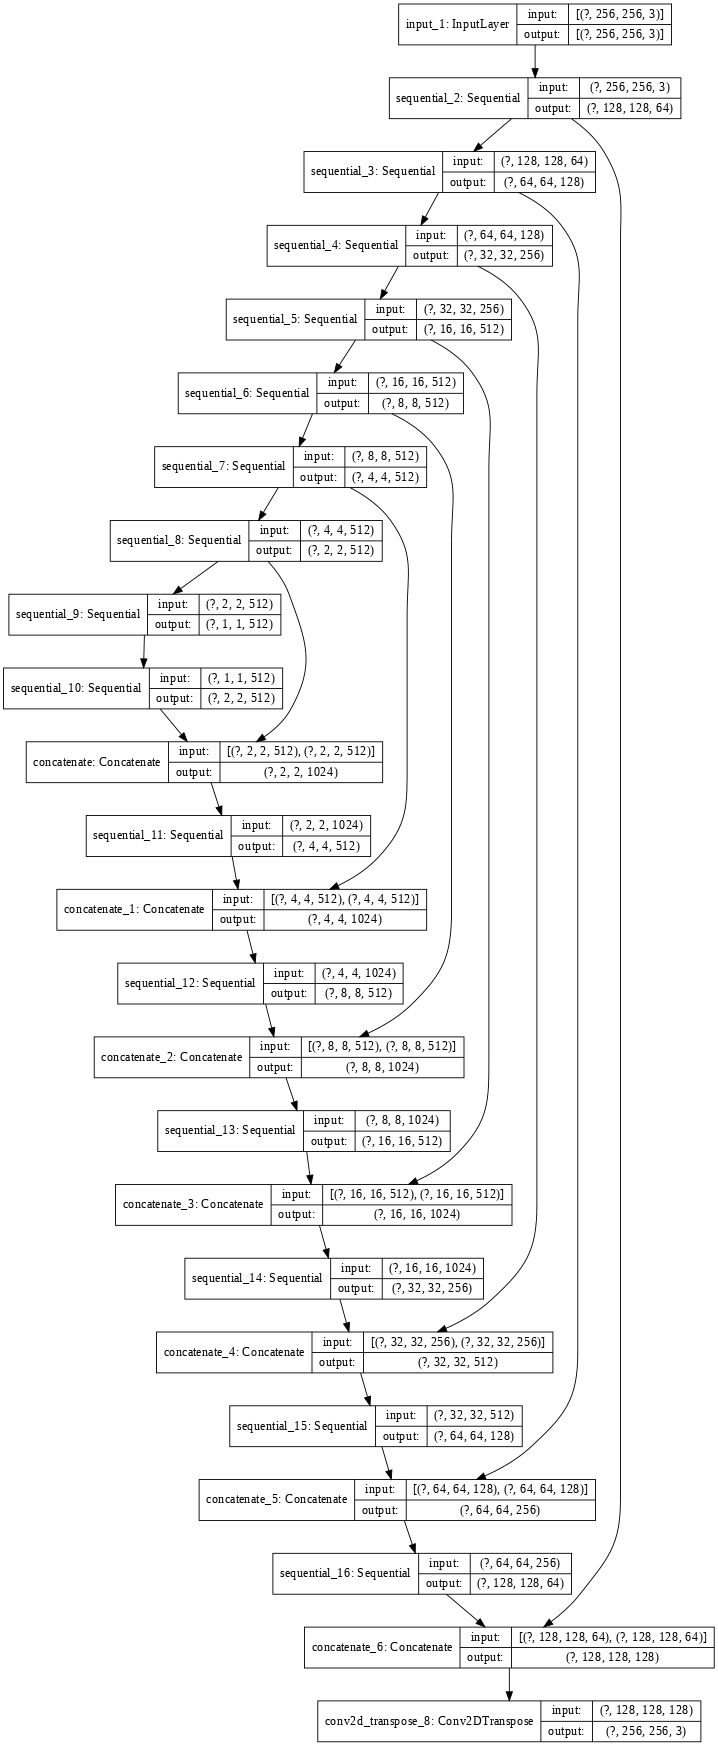

In [25]:
gen = Generator()
tf.keras.utils.plot_model(gen, show_shapes=True, dpi=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


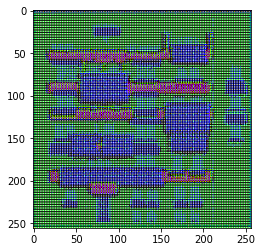

In [26]:
gen_output = gen.predict(x=input_img[tf.newaxis, ...])
plt.imshow(gen_output[0, ...])
plt.show()

## Generator Loss

The generator loss consists of two ideas, one is to trick the discriminator and the other is to mimic or reproduce the target image. For the first part, you try to make the discriminator output closer to 1 (trick it as the real image). For the second part, you can use a simple L1 Norm, or MAE (mean absolute error) between the generator output and the target image to keep the image structure, that is the way purposed by the author of the original paper.

You can combine both them via a formula, `total_loss = trick_loss + structure_loss * lambda`, which the lambda value is customized.

In [27]:
LAMBDA = 100
gen_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [43]:
def generator_loss(dis_generated_output, gen_output, target):
  # trick the discriminator
  trick_loss = gen_loss_object(tf.ones_like(dis_generated_output), dis_generated_output)

  # keep the image structure
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_loss = trick_loss + (LAMBDA * l1_loss)
  return total_loss, trick_loss, l1_loss

# Build the Discriminator

The Discriminator is a `PatchGAN`. The basic idea is regular discriminator GAN would output a value which stands for the probability of being real. However, such a Discriminator is difficult applied in the high-resolution data generation. The PatchGAN is purposed to address the issue. The PatchGAN is composed of several CNNs. The regular Discriminator maps from an original image (i.e. 256x256) to a single scalar value which can be used in classifying real or fake. The PatchGAN maps an original image (i.e. 256x256) to an NxN matrix of output Y, which Y_ij standing for the patch ij in the image is real or fake.

Each block in the Discriminator is composed of a CNN layer, a Batchnorm layer, and a Leakyrelu layer. The shape of the output layer is `[30, 30, 1]`. Each `30x30` patch of the output image classifies `70x70` portion of the image. (Such architecture is called `PatchGAN`.)

The Discriminator takes two inputs and returns one output.
* Take both the input image and the real image as inputs, the Discriminator should classify as real.
* Take both the input image and the generated image as inputs, the Discriminator should classify as fake.
* Here we concatenate both inputs via `tf.concat([inp, tar], axis=-1)`.

In [29]:
def Discriminator():
  initializer = tf.random_normal_initializer(mean=0.0, stddev=0.2)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name="input_image")
  tag = tf.keras.layers.Input(shape=[256, 256, 3], name="target_image")

  concat = tf.keras.layers.concatenate([inp, tag], axis=-1)      # [bs, 256, 256, 3*2]

  x = downsample(64, 4, applyBatchnorm=False)(concat)            # [bs, 128, 128, 64]
  x = downsample(128, 4)(x)                                      # [bs, 64, 64, 128]
  x = downsample(256, 4)(x)                                      # [bs, 32, 32, 256]

  x = tf.keras.layers.ZeroPadding2D()(x)                         # [bs, 34, 34, 256]
  x = tf.keras.layers.Conv2D(512, 
                             kernel_size=(4, 4), 
                             strides=(1, 1), 
                             kernel_initializer=initializer)(x)  # [bs, 31, 31, 256]
  x = tf.keras.layers.BatchNormalization()(x)                    # [bs, 31, 31, 256]
  x = tf.keras.layers.LeakyReLU()(x)                             # [bs, 31, 31, 256]

  x = tf.keras.layers.ZeroPadding2D()(x)                         # [bs, 33, 33, 256]
  y = tf.keras.layers.Conv2D(1, 
                             kernel_size=(4, 4),
                             strides=(1, 1),
                             kernel_initializer=initializer)(x)  # [bs, 30, 30, 1]
  
  model = tf.keras.Model(inputs=[inp, tag], outputs=y)
  return model

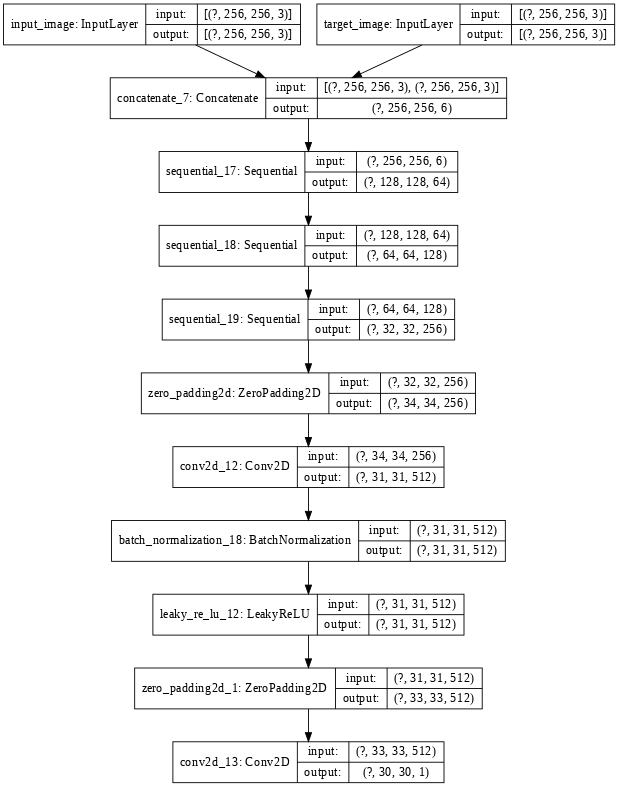

In [30]:
dis = Discriminator()
tf.keras.utils.plot_model(dis, show_shapes=True, dpi=64)

In [31]:
dis_output = dis.predict([input_img[tf.newaxis, ...], gen_output])
dis_output.shape

(1, 30, 30, 1)

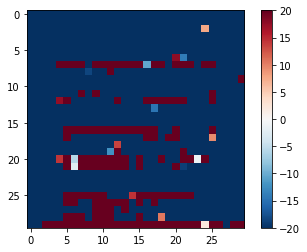

In [32]:
plt.imshow(dis_output[0, :, :, -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

## Discriminator Loss

* The Discriminator loss takes two inputs, one is a generated image and the other is a real image. Both are passed through the Discriminator.

* The result from the PatchGAN collects from each patch. Calculate the binary cross entropy of each and then average them.

In [33]:
dis_loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = dis_loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = dis_loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_loss = real_loss + generated_loss
  return total_loss

In [35]:
disc_real_output = dis.predict([input_img[tf.newaxis, ...], real_img[tf.newaxis, ...]])
disc_generated_output = dis.predict([input_img[tf.newaxis, ...], gen_output])

discriminator_loss(disc_real_output, disc_generated_output).numpy()

448.8842

# Define the Optimizers Checkpoint Savers

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [37]:
ckpt_dir = "./training_checkpoints"
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 gen=gen,
                                 dis=dis)

# Generate Images

Create a function to plot test images during training.

In [38]:
def generate_image(model, input_images, target_images):
  # notice here training is set to True because we want to get batch statistics from the test dataset
  # if training is set to False, we will get the accumlulated statistics from the training dataset
  generated_images = model(input_images, training=True)

  image_titles = ["Input_Image", "Target_Image", "Generated_Image"]
  image_list = [input_images[0], target_images[0], generated_images[0]]

  plt.figure(figsize=(15, 15))
  for i in range(len(image_list)):
    plt.subplot(1, 3, i+1)
    plt.imshow(image_list[i] * 0.5 + 0.5)
    plt.axis("off")
    plt.title(image_titles[i])
  plt.show()

Try the function generating the image.

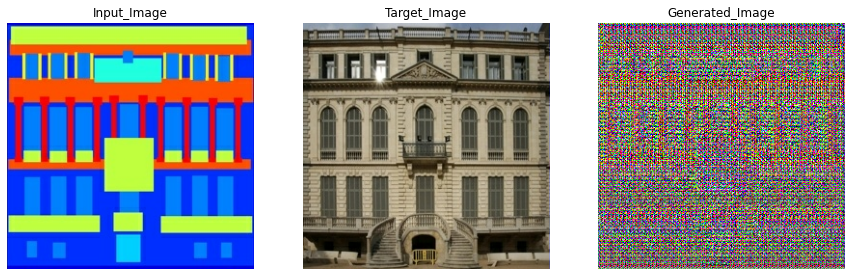

In [39]:
for test_input, test_target in test_dataset.take(1):
  generate_image(gen, test_input, test_target)

# Training

* Each input image generates an image.
* In the training process, the Discriminator receives two sets of inputs. The first set of inputs is input_image and target_image. The second set of inputs is input_image and generated_image.
* We use the above two sets of inputs for the Discriminator loss. Second, we use the Discriminator output of the generated_image,  generated_output, and the target_image for the Generator loss.
* Calculate the gradients and apply them to the variables by optimizers.
* Write the log and monitor it by Tensorboard.

In [40]:
EPOCHS = 150

In [42]:
log_dir = os.path.join(".", "logs")
log_path = os.path.join(log_dir, "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
log_path

'./logs/fit/20200713-031007'

In [44]:
summary_writer = tf.summary.create_file_writer(logdir=log_path)

In [45]:
@tf.function()
def train_step(input_images, target_images, epoch):
  with tf.GradientTape() as genTape, tf.GradientTape() as disTape:
    generated_images = gen(input_images, training=True)

    dis_real_outputs = dis([input_images, target_images], training=True)
    dis_gen_outputs = dis([input_images, generated_images], training=True)

    total_loss, trick_loss, l1_loss = generator_loss(dis_gen_outputs, generated_images, target_images)
    dis_loss = discriminator_loss(dis_real_outputs, dis_gen_outputs)

  generator_gradients = genTape.gradient(total_loss, gen.trainable_variables)
  discriminator_gradients = disTape.gradient(dis_loss, dis.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients, dis.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar("Generator_Total_Loss", total_loss, step=epoch)
    tf.summary.scalar("Generator_Trick_Loss", trick_loss, step=epoch)
    tf.summary.scalar("Generator_L1_Loss", l1_loss, step=epoch)
    tf.summary.scalar("Discriminator_Loss", dis_loss, step=epoch)

In [47]:
def fit(train_ds, test_ds, epochs):
  for epoch in range(epochs):
    start = time.time()

    # view the generator training process
    display.clear_output(wait=True)
    for test_inputs, test_targets in test_ds.take(1):
      generate_image(gen, test_inputs, test_targets)
    
    # training
    for n, (train_inputs, train_targets) in train_ds.enumerate():
      train_step(train_inputs, train_targets, epoch)
      print('.', end="")
      if (n+1) % 80 == 0: print()
    print()

    # checkpoint saving
    if (epoch + 1) % 30 == 0 or epoch == 0:
      checkpoint.save(file_prefix=ckpt_prefix)
    
    print("Epoch {} took {} seconds.".format(epoch, time.time() - start))
  
  # for the last checkpoint
  checkpoint.save(file_prefix=ckpt_prefix)

Start the training process.

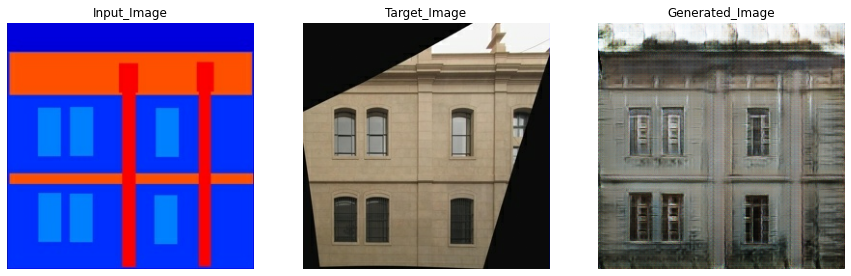

................................................................................................................................................................................................................................................................................................................................................................................................................
Epoch 149 took 71.33682203292847 seconds.


In [51]:
fit(train_dataset, test_dataset, EPOCHS)

## Tensorboard

We use Tensorboard to monitor the training process.

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir}

Interpreting a GAN model is more subtle than a classification or regression model. Things to look for:
* Check neither model has won. If the `Generator_Trick_Loss` (not `Generator_Total_Loss`) or `Discriminator_Loss` is quite low than the other one, it indicates one model dominates the other, and the combined model would fail. (`Generator_Trick_Loss` uses the output from the Discriminator.)
* As the training progresses, the `Generator_Total_Loss` and `l1_loss` should go down.

In [ ]:
!zip -r logs.zip ./logs

# Restore the Checkpoints

In [54]:
!ls {ckpt_dir}

checkpoint		    ckpt-4.index
ckpt-1.data-00000-of-00001  ckpt-5.data-00000-of-00001
ckpt-1.index		    ckpt-5.index
ckpt-2.data-00000-of-00001  ckpt-6.data-00000-of-00001
ckpt-2.index		    ckpt-6.index
ckpt-3.data-00000-of-00001  ckpt-7.data-00000-of-00001
ckpt-3.index		    ckpt-7.index
ckpt-4.data-00000-of-00001


In [55]:
checkpoint.restore(tf.train.latest_checkpoint(ckpt_dir))

# Generate the Image using the Test Dataset

In [58]:
for test_inputs, test_targets in test_dataset.take(10):
  generate_image(gen, test_inputs, test_targets)

Output hidden; open in https://colab.research.google.com to view.